In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda import device
from torchvision import datasets, transforms
from torch.utils.data import DataLoader , random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
LEARNING_RATR = 0.001
EPOCHS = 5
DATA_DIR = "D:\dataset\generate noisy signal"

In [3]:
transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
print("Loading data...")
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transforms)
train_size = int(0.8*len(full_dataset))
test_size = len(full_dataset) - train_size
train_set , test_set = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_set , batch_size=BATCH_SIZE , shuffle=True)
test_loader = DataLoader(test_set , batch_size=BATCH_SIZE , shuffle=False)

class_names = full_dataset.classes
print(f"Classes found: {class_names}")
print(f"Train size: {train_size}, Test size: {test_size}")


Loading data...
Classes found: ['16QAM', '8PSK', 'QPSK']
Train size: 2400, Test size: 601


In [11]:
class RFModulCNN(nn.Module):
    def __init__(self):
        super(RFModulCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1 , out_channels=16 , kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2 , stride=2)
        self.conv2 = nn.Conv2d(in_channels=16 , out_channels=32 , kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*32 , 128)
        self.fc2 = nn.Linear(128, len(class_names))


    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = RFModulCNN().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=LEARNING_RATR)

print("Start training...")
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images , labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total +=labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Training end!")

Using device: cuda
Start training...
Epoch [1/5], Loss: 0.2423, Accuracy: 92.29%
Epoch [2/5], Loss: 0.0066, Accuracy: 99.96%
Epoch [3/5], Loss: 0.0057, Accuracy: 99.92%
Epoch [4/5], Loss: 0.0053, Accuracy: 99.92%
Epoch [5/5], Loss: 0.0050, Accuracy: 99.96%
Training end!


Test Accuracy: 99.83%


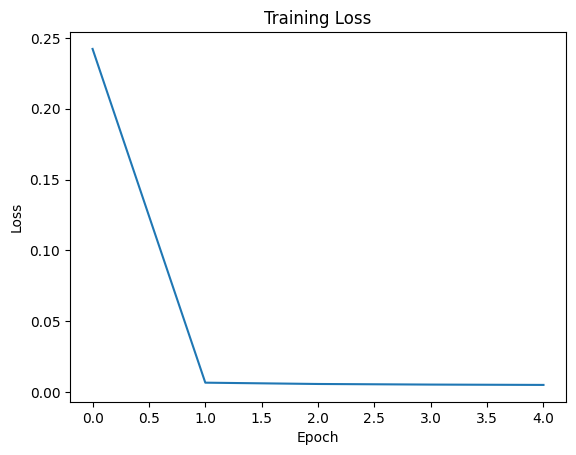

In [13]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images , labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100*correct/total:.2f}%")

plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
torch.save(model.state_dict(), "rf_model_weights.pth")
print("Model saved to 'rf_model_weights.pth'")

Model saved to 'rf_model_weights.pth'
